# 1. Basic preprocessing

In [1]:
# -------------------------
# 1. Import Libraries
# -------------------------

# basic
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import optuna
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ETC
from collections import Counter
from scipy.stats import ttest_ind
import ast

In [2]:
# -------------------------
# 2. Load Data
# -------------------------

df = pd.read_csv('../datasets/airbnb_listings_prague_2024.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10144 non-null  int64  
 1   name                         10144 non-null  object 
 2   listing_url                  10144 non-null  object 
 3   description                  8603 non-null   object 
 4   room_type                    10144 non-null  object 
 5   accommodates                 10144 non-null  int64  
 6   amenities                    10144 non-null  object 
 7   bathrooms                    7907 non-null   float64
 8   bedrooms                     8642 non-null   float64
 9   beds                         10070 non-null  float64
 10  neighborhood_overview        5187 non-null   object 
 11  neighbourhood_cleansed       10144 non-null  object 
 12  latitude                     10144 non-null  float64
 13  longitude       

In [3]:
# -------------------------
# 3. Exclude unnecessary columns for ML
# -------------------------

exclude_cols = [

    # listing information
    'id', 'name', 'listing_url', 'description',

    # location information
    'neighborhood_overview',

    # host information
    'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_listings_count', 'host_neighbourhood', 'host_response_time',

    # booking and price information
    'has_availability', 'availability_30',

    # review and rating information
    'reviews_per_month'

            ]

df = df.drop(columns=exclude_cols)

In [4]:
# -------------------------
# 4. filter inactive hosts
# -------------------------

# Remove records where 'availability_365' is 0 or 365
df = df[(df['availability_365'] > 0) & (df['availability_365'] < 365)]

# 2. Create derived features
- nearby_avg_price: average price of accommodations within 1 km
- has_amenity: boolean columns indicating whether the accommodation has specific amenities

In [5]:
# -------------------------
# 1. Create 'nearby_avg_price' column
# -------------------------

# Define the Haversine function to calculate the shortest distance between two coordinates
def haversine(lat1, lon1, lat2, lon2):
    R = 6371    # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Define a function to calculate average price of nearby listings
def calc_nearby_avg_price(df, radius_km=1.0):
    
    nearby_prices = []
    
    for i, row in df.iterrows():
        lat, lon, room = row["latitude"], row["longitude"], row["room_type"]

        # Filter listings with the same room type
        same_type = df[df["room_type"] == room]

        # Calculate distances from the current listing
        distances = haversine(lat, lon, same_type["latitude"].values, same_type["longitude"].values)

        # Select neighbors within the specified radius (excluding itself)
        mask = (distances <= radius_km) & (distances > 0)
        neighbors = same_type.loc[mask, "price"]

        # Use the overall mean if no nearby listings exist
        if len(neighbors) > 0:
            avg_price = neighbors.mean()
        else:
            avg_price = same_type["price"].mean()

        nearby_prices.append(avg_price)

    df["nearby_avg_price"] = nearby_prices
    return df

# Apply the function and check the result
df = calc_nearby_avg_price(df, radius_km=1.0)
print(df[["room_type", "price", "nearby_avg_price"]])

             room_type   price  nearby_avg_price
0      Entire home/apt  3955.0       4082.644254
1      Entire home/apt  2955.0       4041.924847
2      Entire home/apt  3223.0       3838.465857
3      Entire home/apt  6741.0       3987.581557
4      Entire home/apt  2763.0       4050.070999
...                ...     ...               ...
10139  Entire home/apt  2400.0       3345.302594
10140     Private room   523.0       2287.148148
10141  Entire home/apt  2357.0       2964.016667
10142     Private room  1141.0       2239.445344
10143     Private room  1518.0       2630.076923

[9397 rows x 3 columns]


In [6]:
# -------------------------
# 2. Create 'has_amenity' column
# -------------------------

# --- (1) Check the available amenities list ---

# Convert string-formatted lists into real Python lists
df["amenities"] = df["amenities"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Flatten all amenities into a single list
all_amenities = [amenity for sublist in df["amenities"] for amenity in sublist]

# Count frequency of each amenity
amenity_counts = Counter(all_amenities)

# Convert to DataFrame for easier analysis
amenity_df = (
    pd.DataFrame(amenity_counts.items(), columns=["amenity", "count"])
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)

# Check for the entire amenities list
print(amenity_df.head(20))
amenity_df.to_csv("../datasets/airbnb_amenity_list.csv", index=False)


                    amenity  count
0                   Kitchen   7822
1                Essentials   7672
2                      Wifi   7598
3                Hair dryer   7288
4                 Hot water   7190
5     Dishes and silverware   7014
6                   Hangers   6820
7                Bed linens   6643
8            Cooking basics   6592
9              Refrigerator   6468
10                     Iron   6366
11                  Heating   5399
12                  Shampoo   5393
13                Microwave   5348
14  Long term stays allowed   5016
15         Hot water kettle   4887
16              Smoke alarm   4827
17               Shower gel   4603
18      Dedicated workspace   4564
19             Dining table   4259


In [7]:
# --- (2) Select core amenities ---

# Sort candidate amenities list
candidate_amenities = [
    # core essentials
    'Kitchen', 'Refrigerator', 'Stove', 'Microwave', 'Cooking basics',
    'Wifi', 'Heating', 'Central heating', 'Air conditioning', 'Hot water',
    'Essentials', 'Towels', 'Shampoo', 'Body soap', 'Hair dryer',
    'Washer', 'Dryer', 'Smoke alarm', 'Fire extinguisher', 'Elevator',

    # nice-to-have comforts
    'Dishwasher', 'Coffee maker', 'Coffee', 'Oven', 'Toaster',
    'Bathtub', 'Balcony', 'Patio', 'Parking', 'Self check-in', 'TV', 'Netflix',
    'Long term stays allowed', 'Luggage dropoff allowed',

    # target-specific amenities
    'Crib', 'High chair', 'Baby bath',               # family-oriented
    'Dedicated workspace', 'Ethernet connection',    # business travelers
    'Pets allowed', 'Backyard'                       # pet-friendly
]

# make amenities column string type
df["amenities"] = df["amenities"].astype(str)

# # create a new dataframe for amenities
# df_amenities = df[['price', 'amenities']].copy()

# create boolean columns
for amenity in candidate_amenities:
    col_name = "has_" + amenity.lower().replace(" ", "_").replace("-", "_")
    df[col_name] = df["amenities"].str.contains(amenity, case=False, na=False)

# check result
display(df.head())

,room_type,accommodates,amenities,bathrooms,bedrooms,beds,neighbourhood_cleansed,latitude,longitude,host_response_rate,...,has_netflix,has_long_term_stays_allowed,has_luggage_dropoff_allowed,has_crib,has_high_chair,has_baby_bath,has_dedicated_workspace,has_ethernet_connection,has_pets_allowed,has_backyard
0,Entire home/apt,4,"['Hair dryer', 'Carbon monoxide alarm', 'Dedic...",1.0,1.0,2.0,Praha 1,50.08229,14.41552,100.0,...,False,True,False,True,True,False,True,False,False,False
1,Entire home/apt,3,"['Hair dryer', 'Carbon monoxide alarm', 'Dedic...",1.0,1.0,2.0,Praha 1,50.08830,14.42272,100.0,...,False,True,False,True,True,False,True,False,False,False
2,Entire home/apt,4,"['Hair dryer', 'Free washer – In unit', 'Carbo...",1.5,1.0,2.0,Praha 1,50.08729,14.43179,100.0,...,False,True,True,True,True,True,False,False,False,False
3,Entire home/apt,6,"['Hair dryer', 'Carbon monoxide alarm', 'Shamp...",1.0,2.0,3.0,Praha 1,50.08821,14.42623,100.0,...,False,True,False,True,True,False,False,False,False,False
4,Entire home/apt,3,"['Hair dryer', 'Carbon monoxide alarm', 'Dedic...",1.0,1.0,2.0,Praha 1,50.08228,14.41345,89.0,...,False,True,True,False,False,False,True,True,False,False


In [8]:
# --- (3) filter amenities with statistical verification ---

# create empty list to 
final_amenities = []
exclude_amenities = []

# filter final amenities list
for col in df.columns:
    if col.startswith("has_"):
        # Split into groups
        group1 = df.loc[df[col] == True, "price"]
        group2 = df.loc[df[col] == False, "price"]

        # Welch’s t-test
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False, nan_policy="omit")

        # Filter statistically significant amenities
        if (abs(t_stat) > 1.96 and p_val < 0.05):
            final_amenities.append(col)
        else:
            exclude_amenities.append(col)

# Remove statistically insignificant amenity columns
df = df.drop(columns=exclude_amenities)
df = df.drop(columns='amenities')

C:\Users\toomu\AppData\Roaming\Python\Python313\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


# 3. Machine Learning

In [10]:
# -------------------------
# 1. Split data into train and test sets
# -------------------------

X = df.drop("price", axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [11]:
# -------------------------
# 2. Impute missing values
# -------------------------

# define a function to impute missing values
def impute_by_group_train_test(X_train, X_test, group, cols, strategy="mean"):

    for col in cols:
        # Compute group-level statistics from training data
        if strategy == "mean":
            group_stats = X_train.groupby(group)[col].mean()
        elif strategy == "median":
            group_stats = X_train.groupby(group)[col].median()
        else:
            raise ValueError("Strategy must be 'mean' or 'median'")

        # Define helper to impute with group-level value
        def fill_with_group_stats(row):
            if pd.notnull(row[col]):
                return row[col]
            key = tuple(row[g] for g in group) if isinstance(group, list) else row[group]
            return group_stats.get(key, np.nan)

        # Apply to train and test sets (using train's stats only)
        X_train[col] = X_train.apply(fill_with_group_stats, axis=1)
        X_test[col] = X_test.apply(fill_with_group_stats, axis=1)

        # fallback: fill remaining NaN values with global statistic from training data
        if strategy == "mean":
            fallback = X_train[col].mean()
        elif strategy == "median":
            fallback = X_train[col].median()
        
        X_train[col].fillna(fallback, inplace=True)
        X_test[col].fillna(fallback, inplace=True)

    return X_train, X_test

In [12]:
# --- (1) Impute 'bathrooms', 'bedrooms', and 'beds' ---

# Impute with mean grouped by accommodates
impute_cols = ['bathrooms', 'bedrooms', 'beds']

X_train, X_test = impute_by_group_train_test(
    X_train, X_test,
    group='accommodates',
    cols=impute_cols,
    strategy="mean"
)

C:\Users\toomu\AppData\Local\Temp\ipykernel_11488\4164508925.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(fallback, inplace=True)
C:\Users\toomu\AppData\Local\Temp\ipykernel_11488\4164508925.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [13]:
# --- (2) Impute 'host_response_rate' and 'host_acceptance_rate' ---

# Impute with mean grouped by host_is_superhost
impute_cols = ['host_response_rate', 'host_acceptance_rate']

X_train, X_test = impute_by_group_train_test(
    X_train, X_test,
    group='host_is_superhost',
    cols=impute_cols,
    strategy="mean"
)

C:\Users\toomu\AppData\Local\Temp\ipykernel_11488\4164508925.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(fallback, inplace=True)
C:\Users\toomu\AppData\Local\Temp\ipykernel_11488\4164508925.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [14]:
# --- (3) Impute 'review_scores' columns ---

# Impute with mean grouped by host_is_superhost
impute_cols = [col for col in X_train.columns if col.startswith("review_scores_")]

X_train, X_test = impute_by_group_train_test(
    X_train, X_test,
    group='host_is_superhost',
    cols=impute_cols,
    strategy="mean"
)

C:\Users\toomu\AppData\Local\Temp\ipykernel_11488\4164508925.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(fallback, inplace=True)
C:\Users\toomu\AppData\Local\Temp\ipykernel_11488\4164508925.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [15]:
# -------------------------
# 3. Encoding categorical features
# -------------------------

cat_cols = ['room_type', 'neighbourhood_cleansed', 'nearest_center']

# Apply get_dummies separately
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=False)

In [16]:
# -------------------------
# 4. Scale numerical features
# -------------------------

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on the training set and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [17]:
# -------------------------
# 5. Log transformation
# -------------------------

# Apply log transformation
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [20]:
# -------------------------
# 6. Compare baseline models
# -------------------------

# Define models
models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=22),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(random_state=22),
    "AdaBoost": AdaBoostRegressor(random_state=22),
    "Gradient Boost": GradientBoostingRegressor(random_state=22),
    "XGBoost": XGBRegressor(random_state=22, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=22),
    "CatBoost": CatBoostRegressor(random_state=22, verbose=0)
}

# Create a results list
results = []

# Evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train_log)
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2})

# Create a results DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False).reset_index(drop=True)

# Display the table
display(results_df.style.format({"RMSE": "{:,.2f}", "MAE": "{:,.2f}", "R²": "{:.4f}"}))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 7517, number of used features: 92
[LightGBM] [Info] Start training from score 7.794076


,Model,RMSE,MAE,R²
0,CatBoost,"1,251.56",691.67,0.6516
1,XGBoost,"1,276.68",718.66,0.6375
2,LightGBM,"1,298.95",723.18,0.6247
3,Random Forest,"1,364.13",756.92,0.5861
4,SVM,"1,404.76",763.13,0.5611
5,Gradient Boost,"1,453.81",826.05,0.5299
6,KNN,"1,589.67",921.52,0.4379
7,AdaBoost,"1,721.91","1,096.47",0.3405
8,Decision Tree,"1,824.22","1,085.38",0.2598


In [43]:
# -------------------------
# 7. Hyperparameter tuning
# -------------------------

# --- (1) XGBoost Optuna tuning ---

# Define an objective function
def objective_xgb(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 22,
        "objective": "reg:squarederror"
    }

    # Define model
    model = XGBRegressor(**params)

    # Fit model
    model.fit(X_train_scaled, y_train_log, eval_set=[(X_test_scaled, y_test_log)], verbose=False)

    # Predict
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse


# Run the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

# Show best results
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)

# Train final model
best_params_xgb = study.best_params
best_xgb = XGBRegressor(**best_params_xgb)
best_xgb.fit(X_train_scaled, y_train_log)

# Predict and evaluate on test data
y_pred_log = best_xgb.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

print("\n===== XGBoost (Optimized) =====")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

[I 2025-10-09 01:00:38,188] A new study created in memory with name: no-name-46a4a46e-0910-41e4-9431-501b8761397e


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-09 01:00:39,764] Trial 0 finished with value: 1245.228745512836 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.06783856948808228, 'subsample': 0.8840802806488199, 'colsample_bytree': 0.9977518557903728, 'gamma': 0.004564892093521178, 'min_child_weight': 9}. Best is trial 0 with value: 1245.228745512836.
[I 2025-10-09 01:00:41,758] Trial 1 finished with value: 1313.0154455314173 and parameters: {'n_estimators': 473, 'max_depth': 5, 'learning_rate': 0.04008541735406734, 'subsample': 0.9071765038937573, 'colsample_bytree': 0.821536146243936, 'gamma': 0.26043383798464587, 'min_child_weight': 2}. Best is trial 0 with value: 1245.228745512836.
[I 2025-10-09 01:00:44,235] Trial 2 finished with value: 1300.8070517223375 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.24218548124947598, 'subsample': 0.7876525621666949, 'colsample_bytree': 0.6131170010512047, 'gamma': 0.2336985906891606, 'min_child_weight': 8}. Best is trial 0 with va

In [47]:
# --- (2) CatBoost Optuna tuning ---

# Define an objective function
def objective_cat(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 5.0),
        "random_strength": trial.suggest_float("random_strength", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "loss_function": "RMSE",
        "random_state": 22,
        "verbose": 0
    }

    # Define model
    model = CatBoostRegressor(**params)

    # Fit model
    model.fit(X_train_scaled, y_train_log, eval_set=(X_test_scaled, y_test_log), verbose=0)

    # Predict
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse


# Run optimization
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=30, show_progress_bar=True)

# Show best results
print("Best RMSE:", study_cat.best_value)
print("Best Parameters:", study_cat.best_params)

# Train final model
best_params_cat = study_cat.best_params
best_cat = CatBoostRegressor(**best_params_cat)
best_cat.fit(X_train_scaled, y_train_log)

# Predict and evaluate on test data
y_pred_log = best_cat.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

print("\n===== CatBoost (Optimized) =====")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


[I 2025-10-09 01:07:37,633] A new study created in memory with name: no-name-875e42dc-b326-4536-891e-c52e85ac3a07


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-09 01:08:04,222] Trial 0 finished with value: 1289.2001633284983 and parameters: {'iterations': 479, 'depth': 10, 'learning_rate': 0.04828516698473523, 'l2_leaf_reg': 4.9659575242884095, 'bagging_temperature': 2.764757280136777, 'random_strength': 1.3204156694567177, 'border_count': 121}. Best is trial 0 with value: 1289.2001633284983.
[I 2025-10-09 01:08:51,666] Trial 1 finished with value: 1255.2018718444135 and parameters: {'iterations': 641, 'depth': 10, 'learning_rate': 0.1039144916313521, 'l2_leaf_reg': 1.3344277536937437, 'bagging_temperature': 1.9906850889003322, 'random_strength': 7.733060931841416, 'border_count': 218}. Best is trial 1 with value: 1255.2018718444135.
[I 2025-10-09 01:09:45,653] Trial 2 finished with value: 1298.4075967597464 and parameters: {'iterations': 805, 'depth': 10, 'learning_rate': 0.03316909945556264, 'l2_leaf_reg': 8.426471613671, 'bagging_temperature': 4.798113791411179, 'random_strength': 1.4613261270160571, 'border_count': 144}. Best i

In [51]:
# --- (3) LightGBM Optuna tuning ---

# Define an objective function
def objective_lgb(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 60),
        "max_depth": trial.suggest_int("max_depth", -1, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 22,
        "verbosity": -1
    }

    # Define model
    model = LGBMRegressor(**params)

    # Fit model
    model.fit(X_train_scaled, y_train_log, 
              eval_set=[(X_test_scaled, y_test_log)],
              eval_metric="rmse")

    # Predict
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

# Run optimization
study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

# Show best results
print("Best RMSE:", study_lgb.best_value)
print("Best Parameters:", study_lgb.best_params)

# Train final model
best_params_lgb = study_lgb.best_params
best_lgb = LGBMRegressor(**best_params_lgb)
best_lgb.fit(X_train_scaled, y_train_log)

# Predict and evaluate on test data
y_pred_log = best_lgb.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

print("\n===== LightGBM (Optimized) =====")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

[I 2025-10-09 01:21:10,153] A new study created in memory with name: no-name-6893ba9e-32d6-4b76-8bab-a16bd03a7253


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-09 01:21:11,692] Trial 0 finished with value: 1213.7136699666423 and parameters: {'n_estimators': 810, 'num_leaves': 26, 'max_depth': 20, 'learning_rate': 0.11853690599711929, 'subsample': 0.9987811570468921, 'colsample_bytree': 0.6685239249578782, 'min_child_samples': 21, 'reg_alpha': 0.9517875769465298, 'reg_lambda': 0.2774225865550868}. Best is trial 0 with value: 1213.7136699666423.
[I 2025-10-09 01:21:13,305] Trial 1 finished with value: 1251.5657830785765 and parameters: {'n_estimators': 879, 'num_leaves': 44, 'max_depth': 6, 'learning_rate': 0.026478253527847374, 'subsample': 0.653880589279053, 'colsample_bytree': 0.7023707071185584, 'min_child_samples': 38, 'reg_alpha': 0.8863150099802671, 'reg_lambda': 0.14930240999804734}. Best is trial 0 with value: 1213.7136699666423.
[I 2025-10-09 01:21:14,732] Trial 2 finished with value: 1233.5030313234738 and parameters: {'n_estimators': 547, 'num_leaves': 46, 'max_depth': 22, 'learning_rate': 0.11227862279869731, 'subsample'

In [55]:
# --- (4) Set base models with best parameters ---

final_xgb = XGBRegressor(
    n_estimators = 749, 
    max_depth = 8, 
    learning_rate = 0.030873347281850337, 
    subsample = 0.632902321659436, 
    colsample_bytree = 0.9141070731283496, 
    gamma = 0.017064800711569364, 
    min_child_weight = 6
)

final_cat = CatBoostRegressor(
    iterations = 799, 
    depth = 8, 
    learning_rate = 0.14775998102918722, 
    l2_leaf_reg = 8.386916167191204, 
    bagging_temperature = 1.9345917793580534, 
    random_strength = 2.5935482953813347, 
    border_count = 111
)

final_lgb = LGBMRegressor(
    n_estimators = 984, 
    num_leaves = 27, 
    max_depth = 15, 
    learning_rate = 0.12690944612471114, 
    subsample = 0.8657878046120586, 
    colsample_bytree = 0.829533561277177, 
    min_child_samples = 35, 
    reg_alpha = 0.8610912780678194, 
    reg_lambda = 0.20448565469826563
)

In [56]:
# -------------------------
# 8. Test multiple meta models for stacking
# -------------------------

# --- Base models (already tuned with Optuna) ---
base_models = [
    ('xgb', final_xgb),
    ('cat', final_cat),
    ('lgb', final_lgb)
]

# --- Meta models to test ---
meta_models = {
    "Ridge": Ridge(alpha=1.0, random_state=22),
    "Lasso": Lasso(alpha=0.001, random_state=22),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=22),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=22),
    "GradientBoost": GradientBoostingRegressor(random_state=22)
}

results = []

# --- Loop through meta models ---
for name, meta_model in meta_models.items():
    stack = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )

    stack.fit(X_train_scaled, y_train_log)
    y_pred_log = stack.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append({
        "Meta Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# --- Display results sorted by RMSE ---
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)


      Meta Model         RMSE         MAE        R²
0          Ridge  1197.872603  649.993427  0.680840
2     ElasticNet  1198.394270  649.761387  0.680562
1          Lasso  1198.945446  649.845862  0.680268
4  GradientBoost  1207.043182  659.742798  0.675934
3   RandomForest  1265.793880  715.138964  0.643620


In [62]:
# -------------------------
# 9. Optimize Ridge with Optuna
# -------------------------

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for Ridge
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 500, log=True),  # regularization strength
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga"]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True)
    }

    # Define base models (use your tuned versions)
    base_models = [
        ('xgb', final_xgb),
        ('cat', final_cat),
        ('lgb', final_lgb)
    ]

    # Define meta Ridge model with suggested params
    ridge_meta = Ridge(random_state=22, **params)
    
    # Define stacking ensemble
    model = StackingRegressor(
        estimators=base_models,
        final_estimator=ridge_meta,
        n_jobs=-1
    )

    # Train model on log-transformed target
    model.fit(X_train_scaled, y_train_log)

    # Predict and reverse-transform
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)

    # Evaluate RMSE (you can use MAE or R² instead)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Display results
print("\nBest Parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Re-train final optimized stacking model
best_ridge = Ridge(random_state=22, **study.best_params)
final_model = StackingRegressor(
    estimators = [
        ('xgb', final_xgb),
        ('cat', final_cat),
        ('lgb', final_lgb)
    ],
    final_estimator=best_ridge,
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train_log)
y_pred_log = final_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

# Evaluate
print("\n===== Optimized Ridge Stacking Model =====")
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


[I 2025-10-09 02:44:22,329] A new study created in memory with name: no-name-67b4d186-db87-4341-884f-8950fee4b358


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-09 02:46:04,928] Trial 0 finished with value: 1208.5575540584239 and parameters: {'alpha': 10.47091962423961, 'fit_intercept': False, 'solver': 'cholesky', 'tol': 0.0018099294822957082}. Best is trial 0 with value: 1208.5575540584239.
[I 2025-10-09 02:48:17,381] Trial 1 finished with value: 1197.9890360412578 and parameters: {'alpha': 15.565641431768272, 'fit_intercept': True, 'solver': 'sparse_cg', 'tol': 0.00014955505134524105}. Best is trial 1 with value: 1197.9890360412578.
[I 2025-10-09 02:49:50,764] Trial 2 finished with value: 1209.0011368133075 and parameters: {'alpha': 1.2874472249105335, 'fit_intercept': False, 'solver': 'cholesky', 'tol': 4.669369436723748e-05}. Best is trial 1 with value: 1197.9890360412578.
[I 2025-10-09 02:51:21,716] Trial 3 finished with value: 1197.7849633769417 and parameters: {'alpha': 0.31182050597661903, 'fit_intercept': True, 'solver': 'sparse_cg', 'tol': 0.0007840923439353903}. Best is trial 3 with value: 1197.7849633769417.
[I 2025-10-

In [ ]:
# -------------------------
# 10. Final model
# -------------------------

base_models = [
    ('xgb', final_xgb),
    ('cat', final_cat),
    ('lgb', final_lgb)
]

final_meta = Ridge(
    alpha = 0.08816250947777861, 
    fit_intercept = True, 
    solver = 'lsqr', 
    tol = 0.005453565157341008
)

final_model = StackingRegressor(estimators=base_models, final_estimator=final_meta)
final_model.fit(X_train_scaled, y_train_log)

# Predict and evaluate on test data
y_pred_log = final_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

print("\n===== Final Model =====")
print("Final RMSE:", root_mean_squared_error(y_test, y_pred))
print("Final MAE:", mean_absolute_error(y_test, y_pred))
print("Final R²:", r2_score(y_test, y_pred))


0:	learn: 0.6070564	total: 26.3ms	remaining: 21s
1:	learn: 0.5751369	total: 50ms	remaining: 19.9s
2:	learn: 0.5497370	total: 69.9ms	remaining: 18.5s
3:	learn: 0.5290976	total: 89.8ms	remaining: 17.8s
4:	learn: 0.5096854	total: 107ms	remaining: 17s
5:	learn: 0.4937759	total: 124ms	remaining: 16.4s
6:	learn: 0.4811319	total: 141ms	remaining: 16s
7:	learn: 0.4698738	total: 158ms	remaining: 15.6s
8:	learn: 0.4606459	total: 175ms	remaining: 15.4s
9:	learn: 0.4512862	total: 190ms	remaining: 15s
10:	learn: 0.4440876	total: 207ms	remaining: 14.8s
11:	learn: 0.4365614	total: 224ms	remaining: 14.7s
12:	learn: 0.4305673	total: 242ms	remaining: 14.6s
13:	learn: 0.4249454	total: 267ms	remaining: 15s
14:	learn: 0.4204323	total: 289ms	remaining: 15.1s
15:	learn: 0.4148619	total: 309ms	remaining: 15.1s
16:	learn: 0.4108079	total: 330ms	remaining: 15.2s
17:	learn: 0.4065878	total: 349ms	remaining: 15.1s
18:	learn: 0.4021419	total: 371ms	remaining: 15.2s
19:	learn: 0.3984671	total: 391ms	remaining: 15.2

# 4. Visualization

0:	learn: 0.6070564	total: 33.2ms	remaining: 26.5s
1:	learn: 0.5751369	total: 47.1ms	remaining: 18.8s
2:	learn: 0.5497370	total: 64.3ms	remaining: 17.1s
3:	learn: 0.5290976	total: 83.1ms	remaining: 16.5s
4:	learn: 0.5096854	total: 103ms	remaining: 16.3s
5:	learn: 0.4937759	total: 119ms	remaining: 15.7s
6:	learn: 0.4811319	total: 135ms	remaining: 15.3s
7:	learn: 0.4698738	total: 151ms	remaining: 15s
8:	learn: 0.4606459	total: 169ms	remaining: 14.8s
9:	learn: 0.4512862	total: 186ms	remaining: 14.7s
10:	learn: 0.4440876	total: 204ms	remaining: 14.6s
11:	learn: 0.4365614	total: 223ms	remaining: 14.7s
12:	learn: 0.4305673	total: 241ms	remaining: 14.6s
13:	learn: 0.4249454	total: 257ms	remaining: 14.4s
14:	learn: 0.4204323	total: 276ms	remaining: 14.4s
15:	learn: 0.4148619	total: 303ms	remaining: 14.8s
16:	learn: 0.4108079	total: 329ms	remaining: 15.1s
17:	learn: 0.4065878	total: 349ms	remaining: 15.2s
18:	learn: 0.4021419	total: 365ms	remaining: 15s
19:	learn: 0.3984671	total: 382ms	remaini

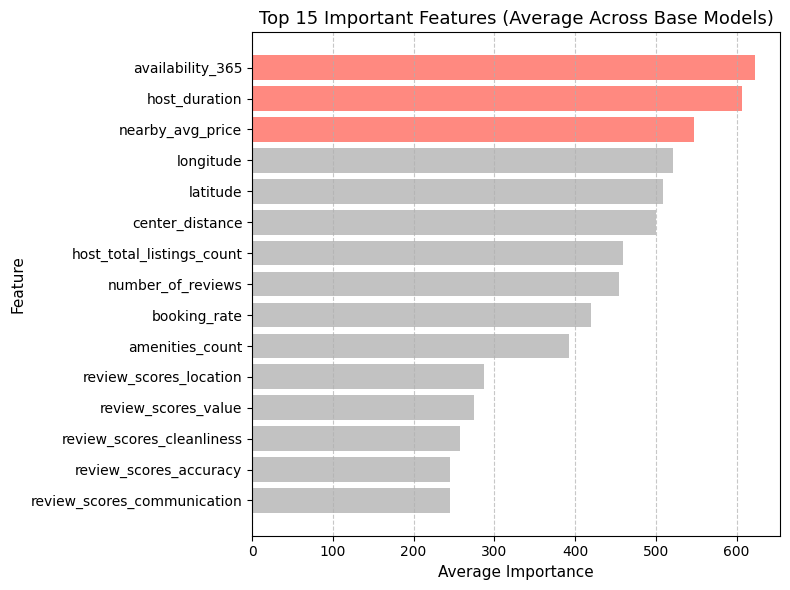

In [72]:
# -------------------------
# 1. Feature Importance
# -------------------------

# Fit models
final_xgb.fit(X_train_scaled, y_train_log)
final_cat.fit(X_train_scaled, y_train_log)
final_lgb.fit(X_train_scaled, y_train_log)

# Collect feature importances
feature_importance_df = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "xgb_importance": final_xgb.feature_importances_,
    "cat_importance": final_cat.get_feature_importance(),
    "lgb_importance": final_lgb.feature_importances_
})

# Calculate average importance
feature_importance_df["avg_importance"] = feature_importance_df[
    ["xgb_importance", "cat_importance", "lgb_importance"]
].mean(axis=1)

# Sort and get top 15
top_features = feature_importance_df.sort_values(
    by="avg_importance", ascending=False
).head(15)

# Highlight top 3
colors = ["#ff8980" if i < 3 else "#c2c2c2" for i in range(len(top_features))]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["avg_importance"], color=colors)
plt.gca().invert_yaxis() 

# Titles and labels
plt.title("Top 15 Important Features (Average Across Base Models)", fontsize=13)
plt.xlabel("Average Importance", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show
plt.tight_layout()
plt.savefig("../assets/feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

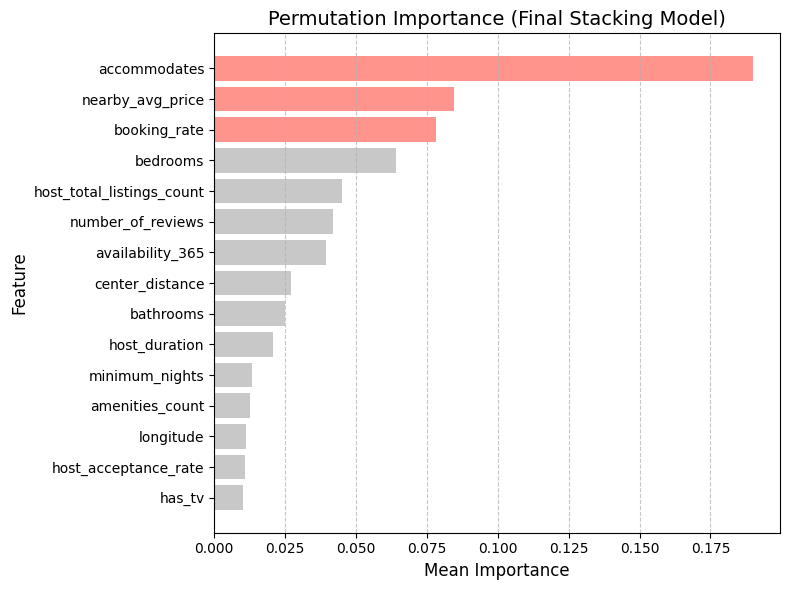

In [70]:
# -------------------------
# 2. Permutation importance (without black error bars)
# -------------------------

# Compute permutation importance
perm_result = permutation_importance(
    final_model, X_test_scaled, y_test_log,
    n_repeats=10,
    random_state=22,
    n_jobs=-1
)

# Convert to DataFrame
perm_df = pd.DataFrame({
    "feature": X_test_scaled.columns,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
}).sort_values(by="importance_mean", ascending=False)

# Select top 15 features
top_features = perm_df.head(15)

# Colors: top 3 pink, rest gray
colors = ["#ff8980" if i < 3 else "#c2c2c2" for i in range(len(top_features))]

# Plot
plt.figure(figsize=(8, 6))
y_pos = np.arange(len(top_features))

plt.barh(
    y_pos,
    top_features["importance_mean"],
    color=colors,
    alpha=0.9
)

plt.yticks(y_pos, top_features["feature"])
plt.gca().invert_yaxis()

# Titles and labels
plt.title("Permutation Importance (Final Stacking Model)", fontsize=14)
plt.xlabel("Mean Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save figure
plt.tight_layout()
plt.savefig("../assets/permutation_importance.png", dpi=300, bbox_inches='tight')
plt.show()


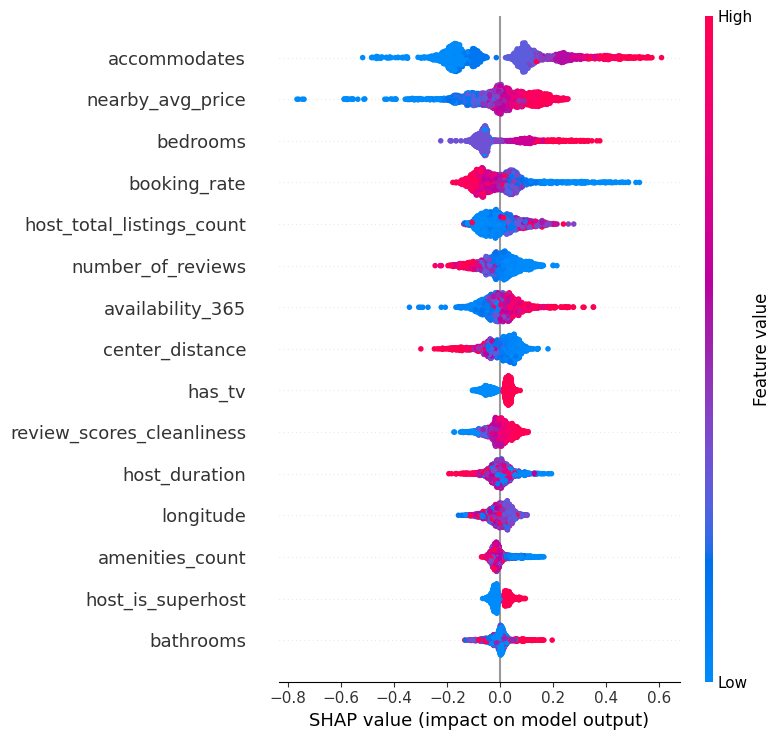

In [71]:
# -------------------------
# 3. SHAP value
# -------------------------

# SHAP for LightGBM
explainer = shap.TreeExplainer(best_lgb)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
save_path = f"../assets/shap_summary.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
shap.summary_plot(shap_values, X_test_scaled, max_display=15)
